## AB Tests

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [ ]:
!pip install EconML
import econml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('dataset_part1_students.csv', sep="\t")
df.head()

     |████████████████████████████████| 3.0MB 5.1MB/s 
     |████████████████████████████████| 358kB 39.0MB/s 
     |████████████████████████████████| 133kB 41.8MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490507 sha256=7194979d62b8f1b21ad649c60beaab2f7bfcf6c213e8ee8ace723f0bde4ef1a1
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefc7736410>,
      dtype=object)

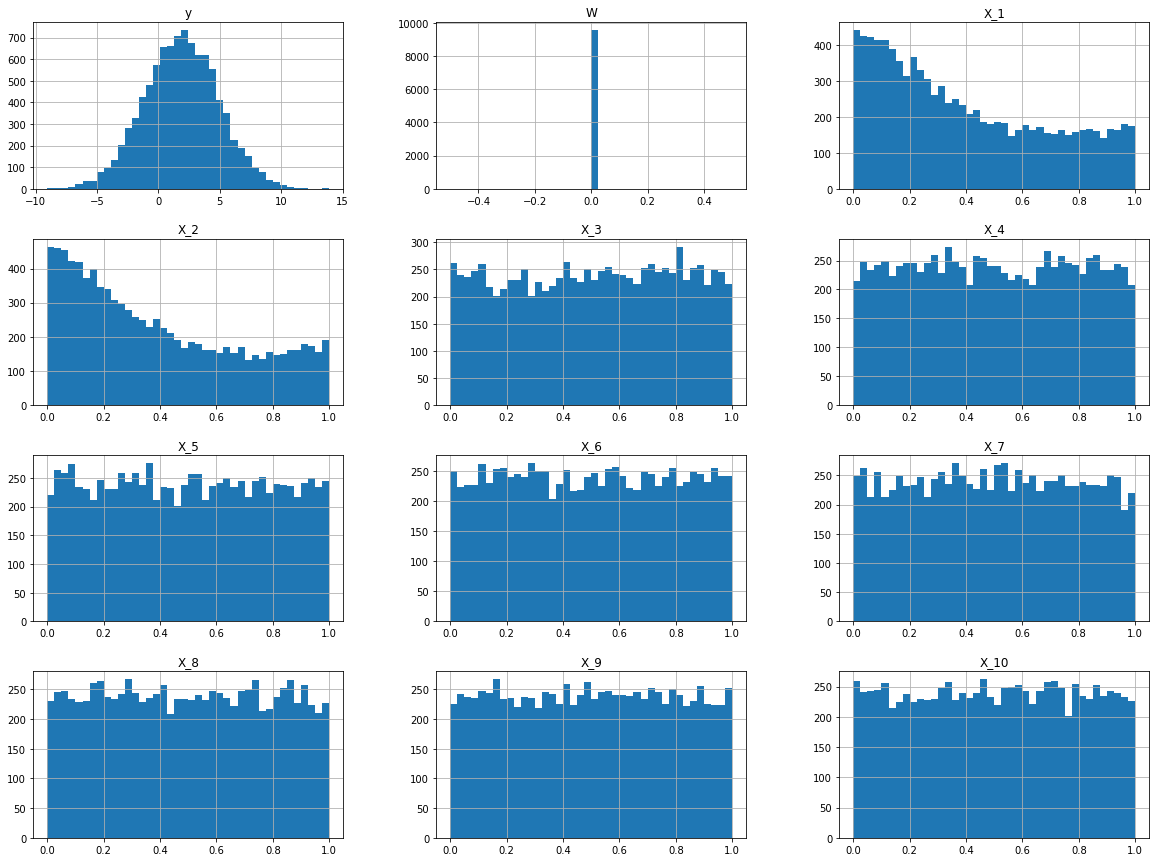

In [ ]:
df.iloc[df.W.values == 0, :].hist(figsize=(20, 15), bins = 40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefc0b42150>,
      dtype=object)

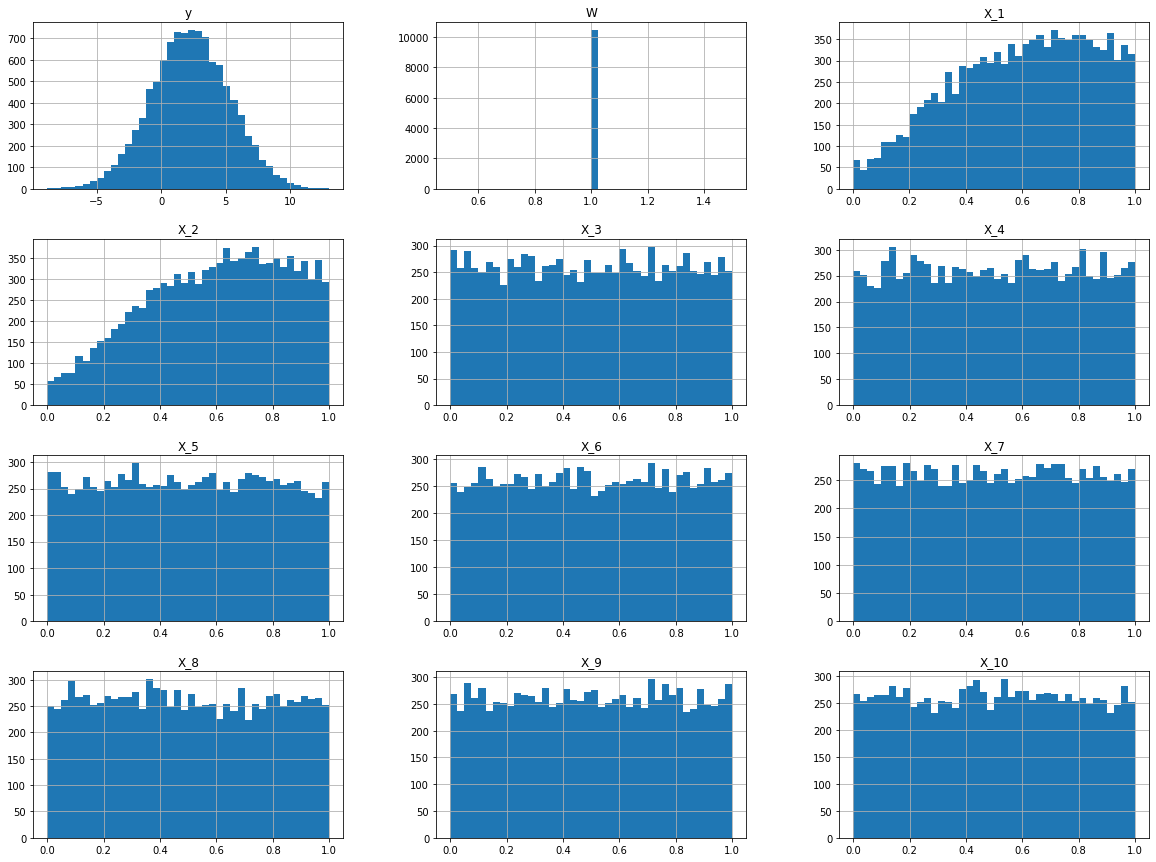

In [ ]:
df.iloc[df.W.values == 1, :].hist(figsize=(20, 15), bins = 40)

In [ ]:
from scipy.stats import normaltest
from scipy.stats import ttest_ind

In [ ]:
y_0 = df.y[df.W == 0].values
y_1 = df.y[df.W == 1].values

In [ ]:
norm_test= normaltest(y_1)  # нулевая гипотеза о нормальности подтвердилась
norm_test

NormaltestResult(statistic=1.340089439214199, pvalue=0.511685694891655)

In [ ]:
norm_test= normaltest(y_0)
norm_test

NormaltestResult(statistic=0.06178545963522806, pvalue=0.9695795744755934)

In [ ]:
a = np.random.normal(0, 1, size=1000)

In [ ]:
norm_test= normaltest(a)  # нулевая гипотеза о нормальности подтвердилась
norm_test

NormaltestResult(statistic=1.8410522658498916, pvalue=0.3983094222443042)

In [ ]:
res = ttest_ind(y_0, y_1, equal_var = False)  # нулевая гипотеза о равенстве (при допущении разных дисперсий) отклонена
res

Ttest_indResult(statistic=-9.332608430209014, pvalue=1.1387356403808485e-20)

In [ ]:
# по x_1 и x_2 видно, что эксперимент не рандомизированный 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression

In [ ]:
# df.y[df.W.values == 1] +=2  # для теста

In [ ]:
model = LogisticRegressionCV().fit(df.iloc[:, 2:], df.W)

In [ ]:
weights = model.predict_proba(df.iloc[:, 2:])

In [ ]:
w = np.ones_like(weights[:, 0])
w[df.W.values == 0] /= weights[df.W.values == 0, 0]
w[df.W.values == 1] /= weights[df.W.values == 1, 1]
w

array([13.74949116,  1.81675312,  2.45337219, ...,  2.09364365,
        2.02143297,  1.85245305])

In [ ]:
Model = LinearRegression()
Model.fit(df.iloc[:, 1:], df.y.values, sample_weight=w)
Model.coef_[0]  # Propensity Score

0.5914682363919443

In [ ]:
t = (df.y[df.W.values == 1].values.mean()- df.y[df.W.values == 0].values).mean()  # наивная оценка
t

0.40010310554442635

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from econml import metalearners

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x_learner = metalearners.XLearner(models=RandomForestRegressor(max_depth=5))
x_learner.fit(df.y.values, T=df.W.values, X=df.iloc[:, 2:].values)
x_learner.ate(X=df.iloc[:, 2:].values)

In [ ]:
t_learner = metalearners.TLearner(models=RandomForestRegressor(max_depth=5))
t_learner.fit(df.y.values, T=df.W.values, X=df.iloc[:, 2:].values)
t_learner.ate(X=df.iloc[:, 2:].values)

In [ ]:
s_learner = metalearners.SLearner(overall_model=RandomForestRegressor(max_depth=5))
s_learner.fit(df.y.values, T=df.W.values, X=df.iloc[:, 2:].values)
s_learner.ate(X=df.iloc[:, 2:].values)

Судя по полученным полученные значения при uplif моделировании (особенно s) довольно близки к наивной оценке. При это взвешенная оценка(если я ее правильно посчитал) отличается в полтора раза. 

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [ ]:
df2 = pd.read_csv('dataset_part2_students.csv', sep="\t")
df2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


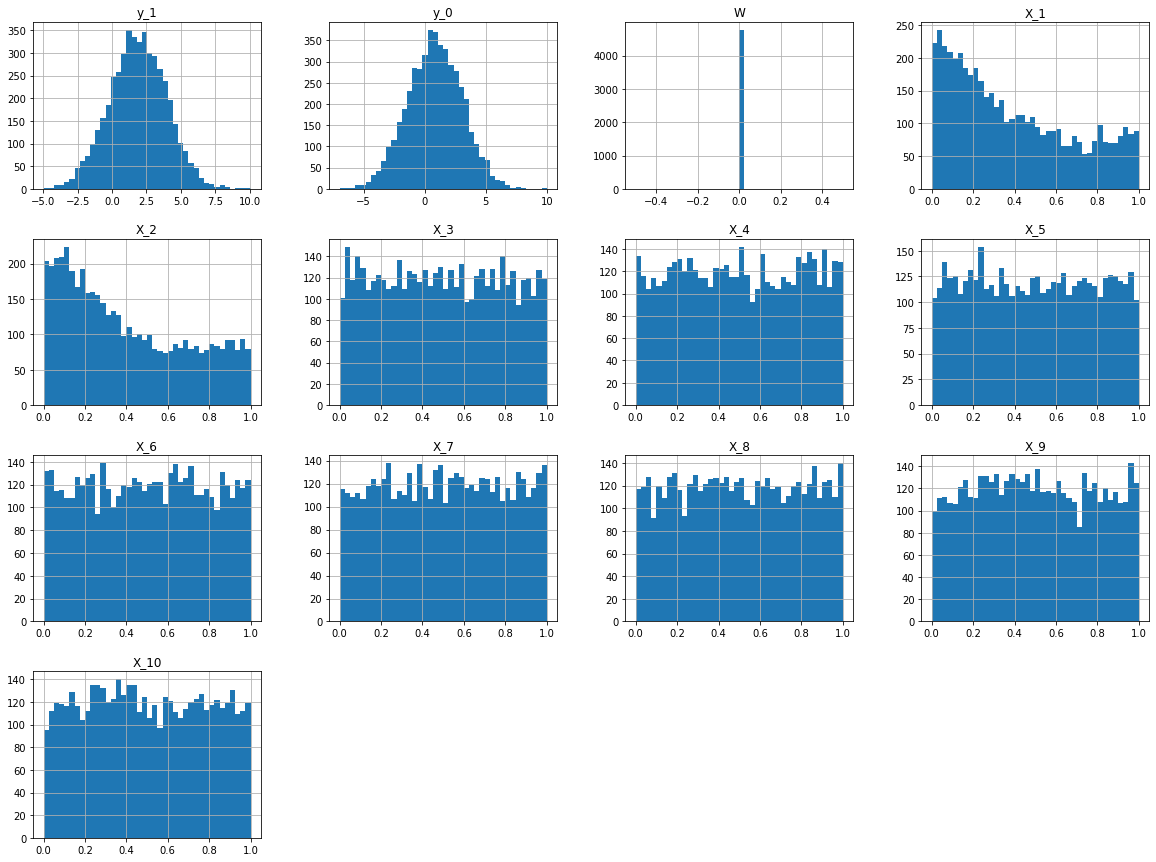

In [ ]:
df2.iloc[df2.W.values == 0, :].hist(figsize=(20, 15), bins = 40)  # есть смещение даже без воздействия
None

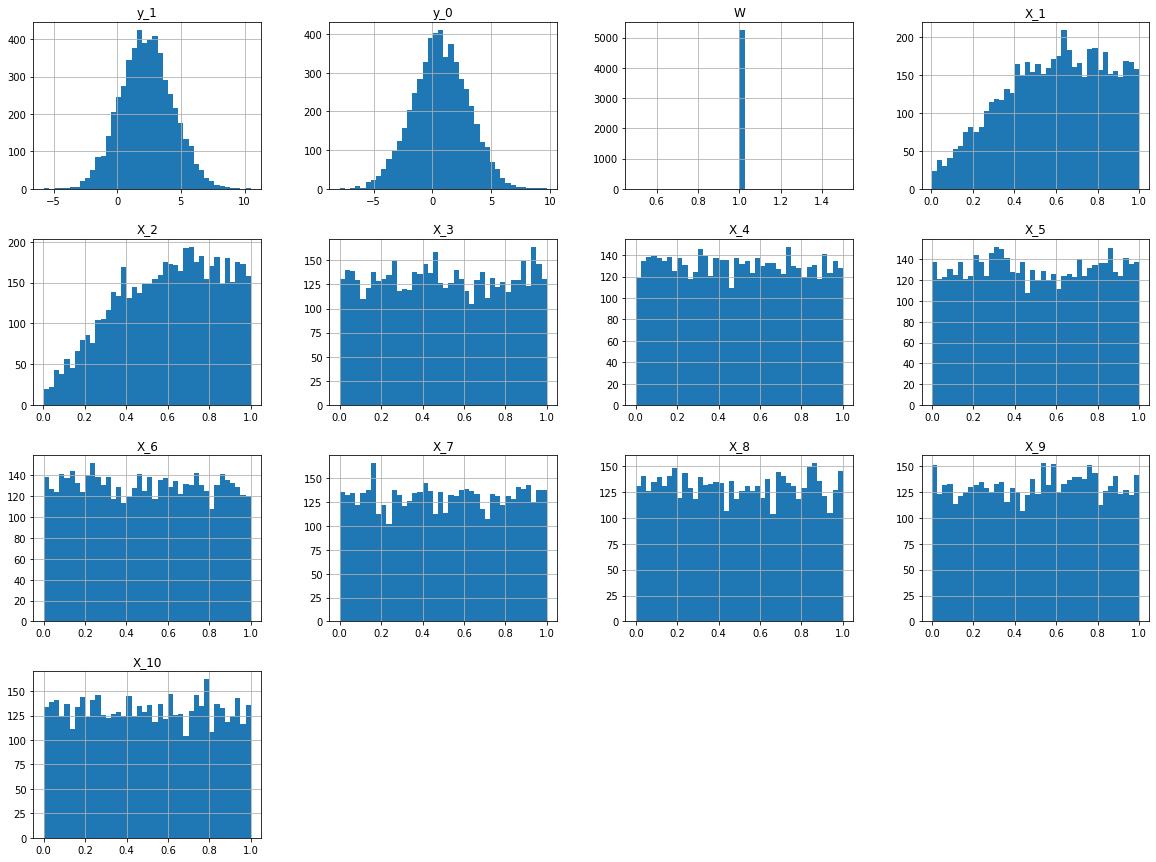

In [ ]:
df2.iloc[df2.W.values == 1, :].hist(figsize=(20, 15), bins = 40)
None

In [ ]:
(df2.y_1[df2.W.values == 1] - df2.y_0[df2.W.values == 1]).values.mean()

In [ ]:
(df2.y_1[df2.W.values == 0] - df2.y_0[df2.W.values == 0]).values.mean()

In [ ]:
df2.y_1[df2.W.values == 1].values.mean() - df2.y_1[df2.W.values == 0].values.mean()

In [ ]:
norm_test_0_0 = normaltest(df2.y_0[df2.W.values == 0].values)  # нулевая гипотеза о нормальности принимается
norm_test_0_0

NormaltestResult(statistic=2.4947774726276, pvalue=0.2872539140777797)

In [ ]:
norm_test_1_0 = normaltest(df2.y_1[df2.W.values == 0].values)  # нулевая гипотеза о нормальности принимается
norm_test_1_0

NormaltestResult(statistic=0.04170043573953361, pvalue=0.9793656450567212)

In [ ]:
norm_test_0_1 = normaltest(df2.y_0[df2.W.values == 1].values)  # нулевая гипотеза о нормальности принимается
norm_test_0_1

NormaltestResult(statistic=0.8639458983187192, pvalue=0.6492269385820693)

In [ ]:
norm_test_1_1 = normaltest(df2.y_1[df2.W.values == 1].values)  # нулевая гипотеза о нормальности принимается
norm_test_1_1

NormaltestResult(statistic=5.547707153441431, pvalue=0.062420996569396064)

In [ ]:
y_0 = df2.y_0[df2.W.values == 0]
y_1 = df2.y_0[df2.W.values == 1]
t_test_0 = ttest_ind(y_0, y_1, equal_var = False)  # нулевая гипотеза о равенстве (при допущении разных дисперсий) отклонена
t_test_0

Ttest_indResult(statistic=2.7014202424371874, pvalue=0.0069160683710655525)

In [ ]:
y_0 = df2.y_1[df2.W.values == 0]
y_1 = df2.y_1[df2.W.values == 1]
t_test_1 = ttest_ind(y_0, y_1, equal_var = False)  # нулевая гипотеза о равенстве (при допущении разных дисперсий) отклонена
t_test_1

Ttest_indResult(statistic=-10.430531043827909, pvalue=2.433950215267867e-25)

In [ ]:
model = LogisticRegressionCV().fit(df2.iloc[:, 3:], df2.W)
weights = model.predict_proba(df2.iloc[:, 3:])
w = np.ones_like(weights[:, 0])
w[df2.W.values == 0] /= weights[df2.W.values == 0, 0]
w[df2.W.values == 1] /= weights[df2.W.values == 1, 1]
w

array([1.36578162, 1.12782183, 3.12124026, ..., 1.7342246 , 1.83581944,
       2.43941428])

In [ ]:
LR2 = LinearRegression().fit(df2.iloc[:, 1:].values, df2.y_1.values, sample_weight=w)  # взвешенная анкова
LR2.coef_[1]  # оценка ate без учета "времени"

In [ ]:
teta = np.cov(df2.y_1.values, df2.y_0.values, ddof=False)[0][0] / np.var(df2.y_0.values)
ate = df2.y_1.values - (df2.y_0.values - df2.y_0.values.mean()) * teta
ate.mean()  # что то не то (не учитывает 'время')

In [ ]:
columns = ['y_0','X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10']

In [ ]:
x_learner = metalearners.XLearner(models=RandomForestRegressor(max_depth=5))
x_learner.fit(df2.y_1.values, T=df2.W.values, X=df2[columns].values)
x_learner.ate(X=df2[columns].values)

In [ ]:
t_learner = metalearners.TLearner(models=RandomForestRegressor(max_depth=5))
t_learner.fit(df2.y_1.values, T=df2.W.values, X=df2[columns].values)
t_learner.ate(X=df2[columns].values)

In [ ]:
s_learner = metalearners.SLearner(overall_model=RandomForestRegressor(max_depth=5))
s_learner.fit(df2.y_1.values, T=df2.W.values, X=df2[columns].values)
s_learner.ate(X=df2[columns].values)

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [ ]:
df3 = pd.read_csv('dataset_part3_students.csv', sep="\t")
df3.treatment[df3.treatment.values == 'control'] = 0
df3.treatment[df3.treatment.values == 'treatment'] = 1
df3.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


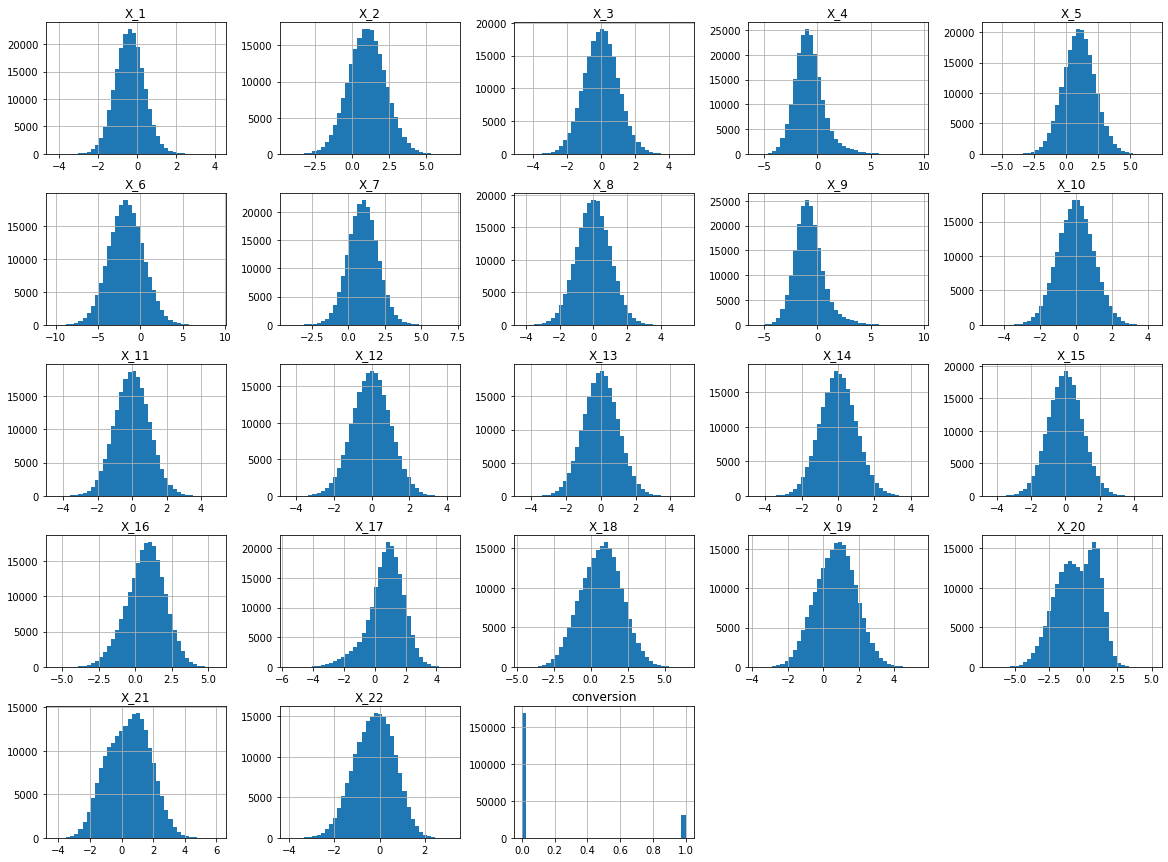

In [ ]:
df3.hist(figsize=(20, 15), bins=40)
None

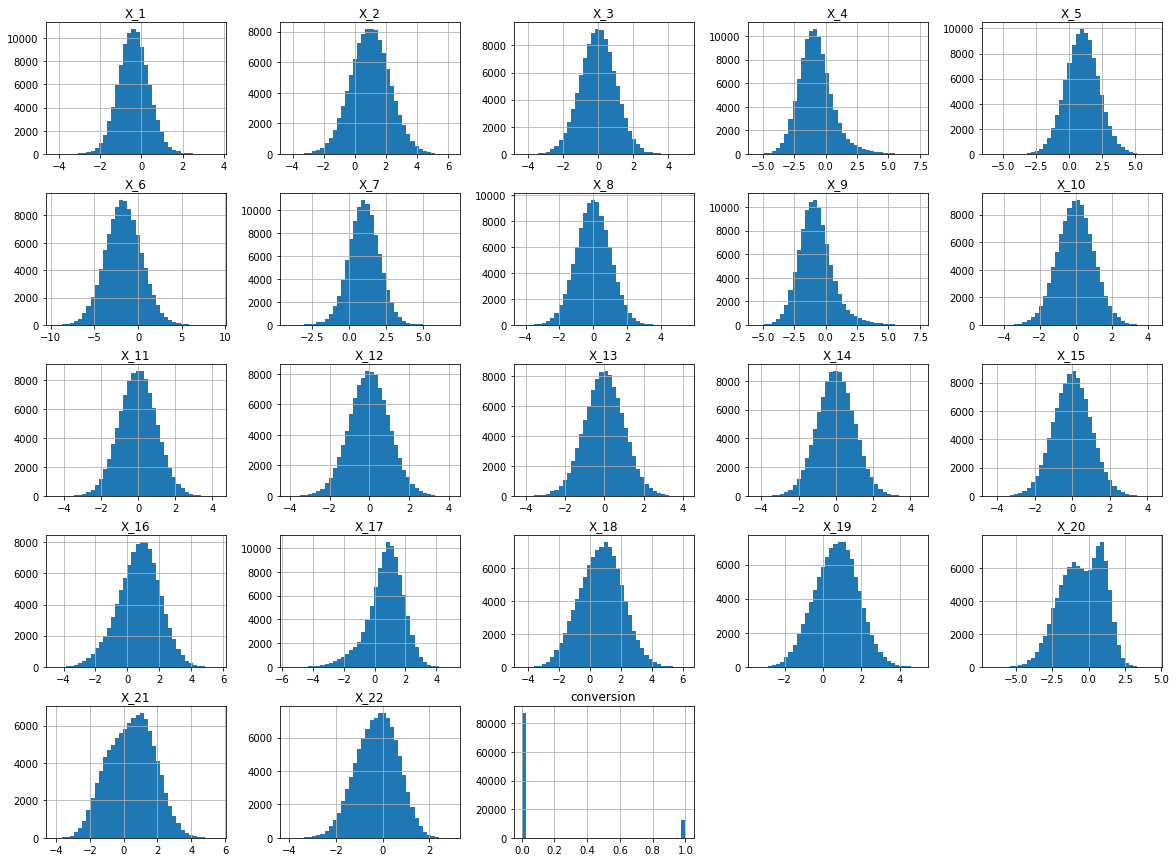

In [ ]:
df3.iloc[df3.treatment.values == 0, :].hist(figsize=(20, 15), bins = 40)
None

In [ ]:
x_learner = metalearners.XLearner(models=RandomForestRegressor(max_depth=5), cate_models = RandomForestRegressor(max_depth=5))
x_learner.fit(Y = df3.conversion.values, T=df3.treatment.values, X=df3.iloc[:, 1:-1].values)
x_learner.ate(X=df3.iloc[:, 1:-1].values)

In [ ]:
# предельный эффект (это не оч понятная часть вопроса, но я понял так)
effect_x = x_learner.marginal_effect(T = df3.treatment.values, X=df3.iloc[:, 1:-1].values)
effect_x[effect_x > 0].mean()

In [ ]:
s_learner = metalearners.SLearner(overall_model=RandomForestRegressor(max_depth=5))
s_learner.fit(Y = df3.conversion.values, T=df3.treatment.values, X=df3.iloc[:, 1:-1].values)
s_learner.ate(X=df3.iloc[:, 1:-1].values)

In [ ]:
effect_s = s_learner.marginal_effect(T = df3.treatment.values, X=df3.iloc[:, 1:-1].values)
effect_s[effect_s > 0].mean() # слишком много получилось

In [ ]:
t_learner = metalearners.TLearner(models=RandomForestRegressor(max_depth=5))
t_learner.fit(Y = df3.conversion.values, T=df3.treatment.values, X=df3.iloc[:, 1:-1].values)
t_learner.ate(X=df3.iloc[:, 1:-1].values)

In [ ]:
effect_t = t_learner.marginal_effect(T = df3.treatment.values, X=df3.iloc[:, 1:-1].values)
effect_t[effect_t > 0].mean()

In [ ]:
d_learner = metalearners.DomainAdaptationLearner(models=RandomForestRegressor(max_depth=5), final_models=RandomForestRegressor(max_depth=5))
d_learner.fit(Y = df3.conversion.values, T=df3.treatment.values, X=df3.iloc[:, 1:-1].values)
d_learner.ate(X=df3.iloc[:, 1:-1].values)

In [ ]:
effect_d = d_learner.marginal_effect(T = df3.treatment.values, X=df3.iloc[:, 1:-1].values)
effect_d[effect_d > 0].mean()